# Spectral Clustering

In this notebook, the robustness of the method chosen in the Callaham paper is tested by exploring spectral clustering for unsupervised dominant balance identification. Spectral clustering functions by constructing a graph network between points based on a defined condition, which means it does not rely on Eulcidean Distance. This means it better able to handle different sized and shaped clusters. However, it does not have the capacity to take in new data points after training, which brings a computational cost difficulty.

First, we do the same preprocessing done for the Boundary_Layer notebook. We'll get the data and the derivatives and obtain the equation space representation of the terms.

In [19]:
import numpy as np
from numpy.random import randint
import h5py
import matplotlib.pyplot as plt
import sys
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import SparsePCA
from scipy.io import loadmat
from scipy import sparse, linalg
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint
from scipy.interpolate import interp1d


# adding Tools to the system path
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import blasius_solution as bs


import matplotlib as mpl

mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")
mpl.rc("figure", figsize=(15, 3))
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)
mpl.rc("axes", labelsize=20)
mpl.rc("axes", titlesize=20)
%config InlineBackend.figure_format = 'retina'


from matplotlib.colors import ListedColormap

# Seaborn colormap
import seaborn as sns

sns_list = sns.color_palette("deep").as_hex()
sns_list.insert(0, "#ffffff")
sns_cmap = ListedColormap(sns_list)

cm = sns_cmap

mpl_colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

# 1. Preprocessing

## a. Load the data

In [20]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [21]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u = np.array(file["um"])
v = np.array(file["vm"])
p = np.array(file["pm"])
Ruu = np.array(file["uum"]) - u**2
Ruv = np.array(file["uvm"]) - u * v
Rvv = np.array(file["uvm"]) - v**2

In [22]:
# Visualize by wall-normal Reynolds stress
X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

## b. Get the finite difference derivatives to estimate the gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [23]:
# Get space steps

dx = x[1] - x[0]
dy = y[1:] - y[:-1]

nx = len(x)  # Number of points in x
ny = len(y)  # Number of points in y

Dy = sparse.diags([-1, 1], [-1, 1], shape=(ny, ny)).toarray()

# Get 2nd order forward/backwards at the boundaries
Dy[0, :3] = np.array([-3, 4, -1])
Dy[-1, -3:] = np.array([1, -4, 3])

for i in range(ny - 1):
    Dy[i, :] = Dy[i, :] / (2 * dy[i])
Dy[-1, :] = Dy[-1, :] / (2 * dy[-1])

# Repeat this for the x-direction
Dy = sparse.block_diag([Dy for i in range(nx)])  # Creates a block diagonal matrix
# with the Dy matrix on the diagonal

Dx = sparse.diags([-1, 1], [-ny, ny], shape=(nx * ny, nx * ny))
Dx = sparse.lil_matrix(Dx)

# Get 2nd order forwards/backwards with boundary conditions
for i in range(ny):
    Dx[i, i] = -3
    Dx[i, ny + i] = 4
    Dx[i, 2 * ny + i] = -1
    Dx[-(i + 1), -(i + 1)] = 3
    Dx[-(i + 1), -(ny + i + 1)] = -4
    Dx[-(i + 1), -(2 * ny + i + 1)] = 1
Dx = Dx / (2 * dx)

Dx = sparse.csr_matrix(Dx)
Dy = sparse.csr_matrix(Dy)

Dxx = 2 * (Dx @ Dx)
Dyy = 2 * (Dy @ Dy)

In [24]:
# Flatten arrays for matrix multiplication, using fortran ordering
u = u.flatten("F")
v = v.flatten("F")
p = p.flatten("F")
Ruu = Ruu.flatten("F")
Ruv = Ruv.flatten("F")

# Get derivatives
ux = Dx @ u
uy = Dy @ u
vx = Dx @ v
vy = Dy @ v
px = Dx @ p
py = Dy @ p
lap_u = (Dxx + Dyy) @ u
Ruux = Dx @ Ruu
Ruvy = Dy @ Ruv

## c. Equation space representation

In [25]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

In [26]:
# Get terms stored as features, keeping track of the space position
X_flat = X.flatten("F")
Y_flat = Y.flatten("F")
features = (
    1e3
    * np.vstack(
        [u * ux, v * uy, px, nu * lap_u, Ruvy, Ruux, 1e-3 * X_flat, 1e-3 * Y_flat]
    ).T
)
nfeatures = features.shape[1] - 2

# 2. Spectral Clustering


Describe spectral clustering

Due to computational cost, the model is trained and used only on a subset of the data. One can use a computer with large amounts of memory to run this for a larger fraction of the dataset.

## a. Train and predict model

In [109]:
# Initialise the Spectral Clustering model
nc = 6  # Number of clusters
seed = np.random.randint(2**32)
seed = 75016  #  Keep a seed for debugging/plotting
np.random.seed(seed)
model = SpectralClustering(
    n_clusters=nc, affinity="nearest_neighbors", n_neighbors=8, random_state=seed
)

In [110]:
# Train on only a subset of the data
sample_pct = 0.02
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]
features_sc = features[mask, :]
model.fit_predict(features_sc[:, :6])

array([0, 0, 4, ..., 1, 3, 4], dtype=int32)

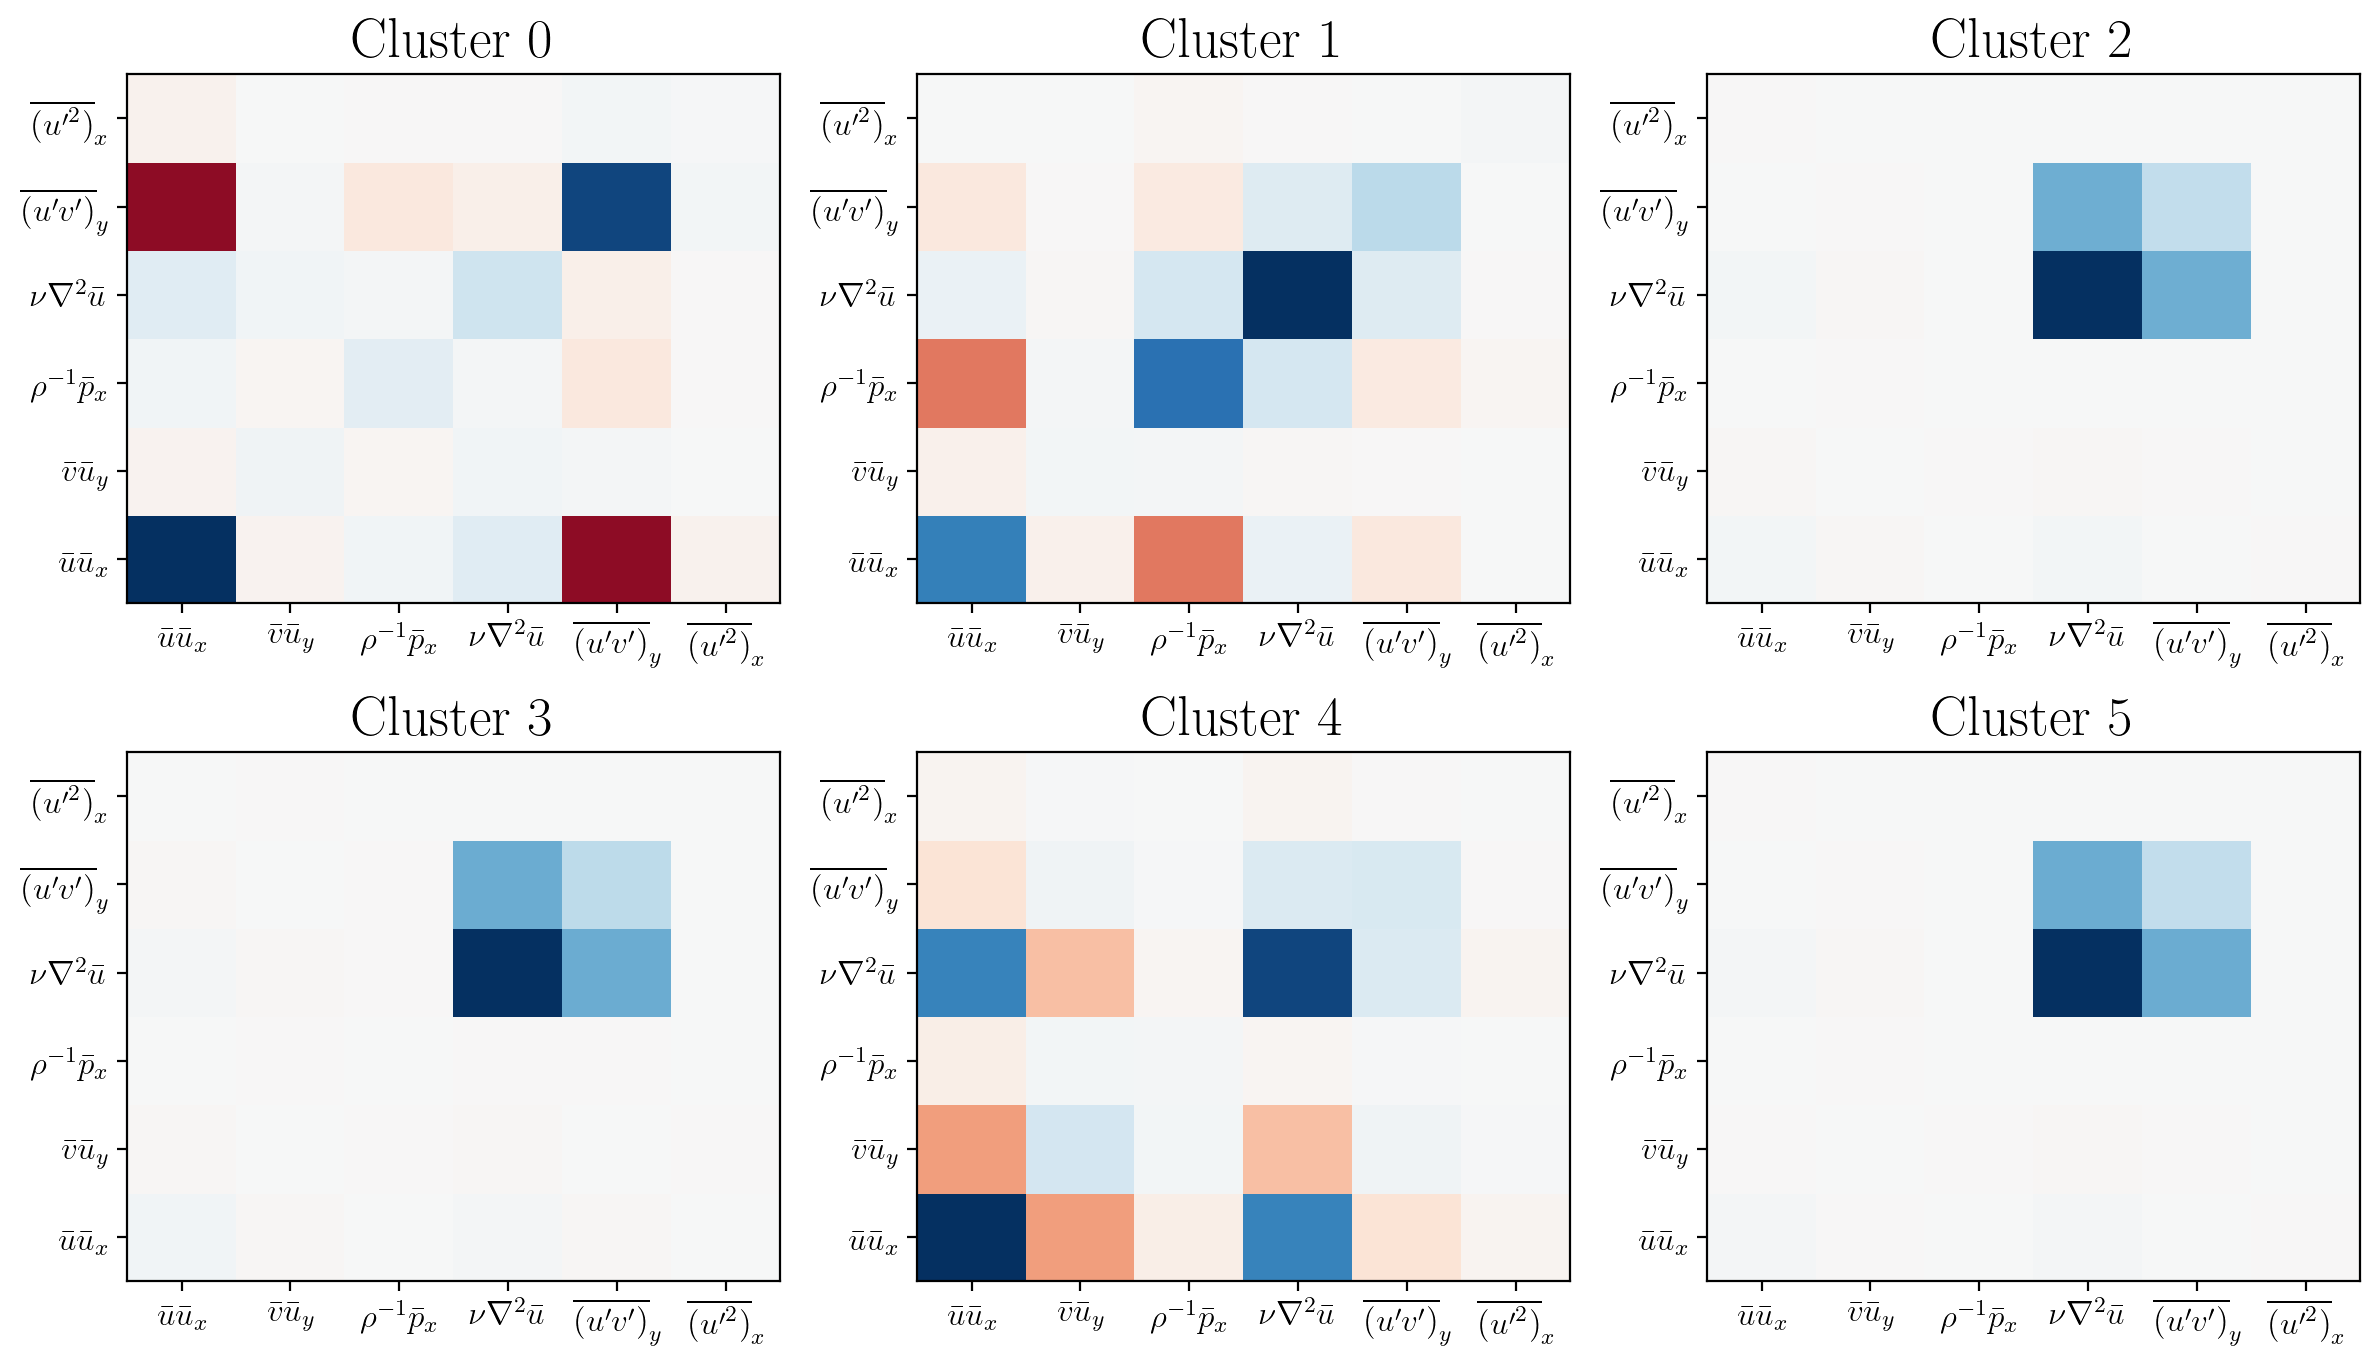

In [111]:
# Get covariances in each cluster
covs = np.zeros((nc, nfeatures, nfeatures))
for i in range(nc):
    mask_ = model.labels_ == i
    covs[i, :, :] = np.cov(features_sc[mask_, :6].T)

# Plot the covariances
pf.plot_cov_mat(covs, nfeatures, nc, "Other")

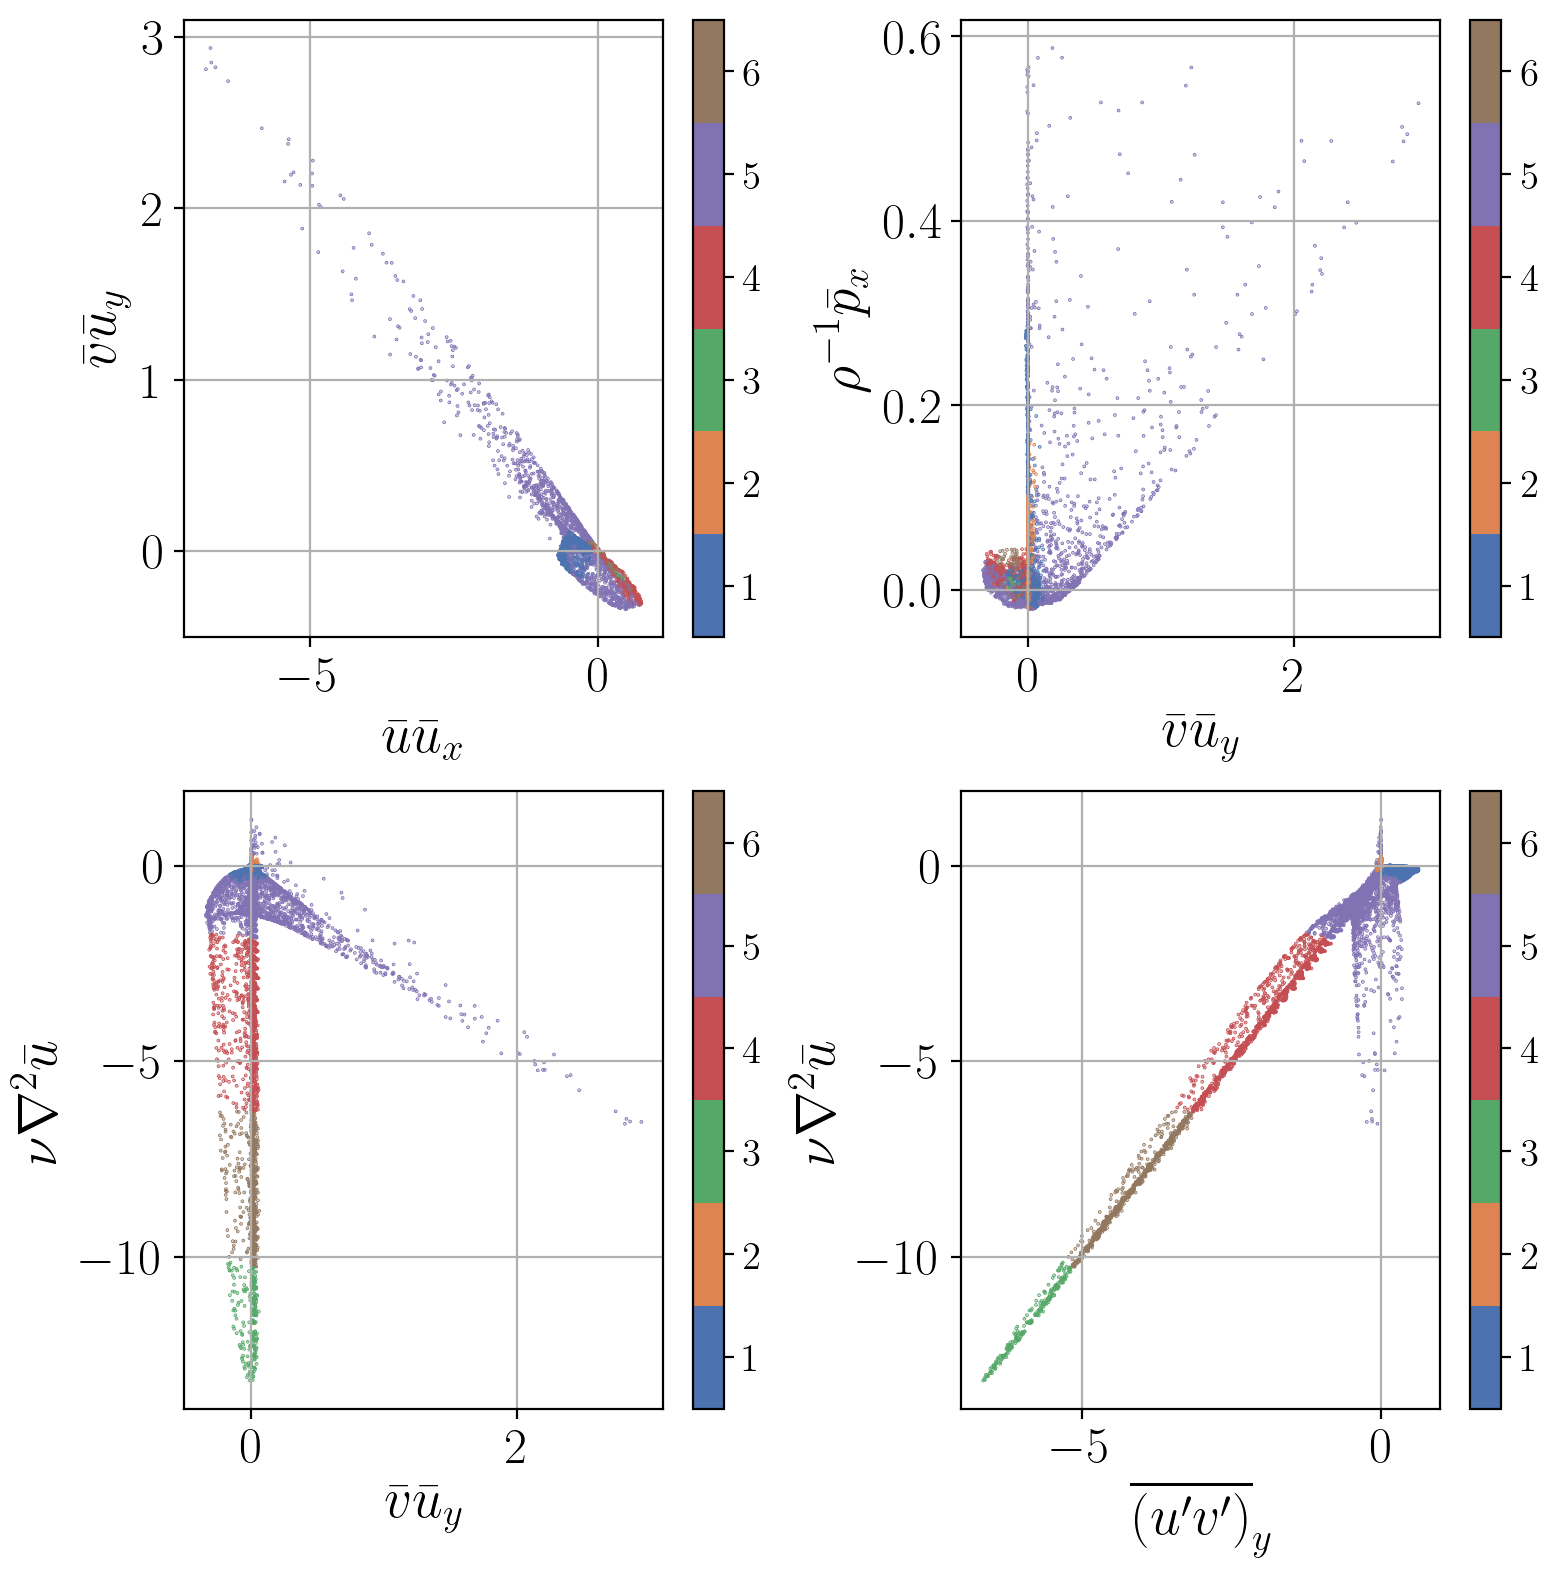

In [112]:
# Visualize GMM clustering with 2D views of equation space
cluster_idx = model.labels_ + 1
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nc + 1.5)

pf.plot_clustering_2d_eq_space(features_sc[:, :6], cluster_idx, nc)

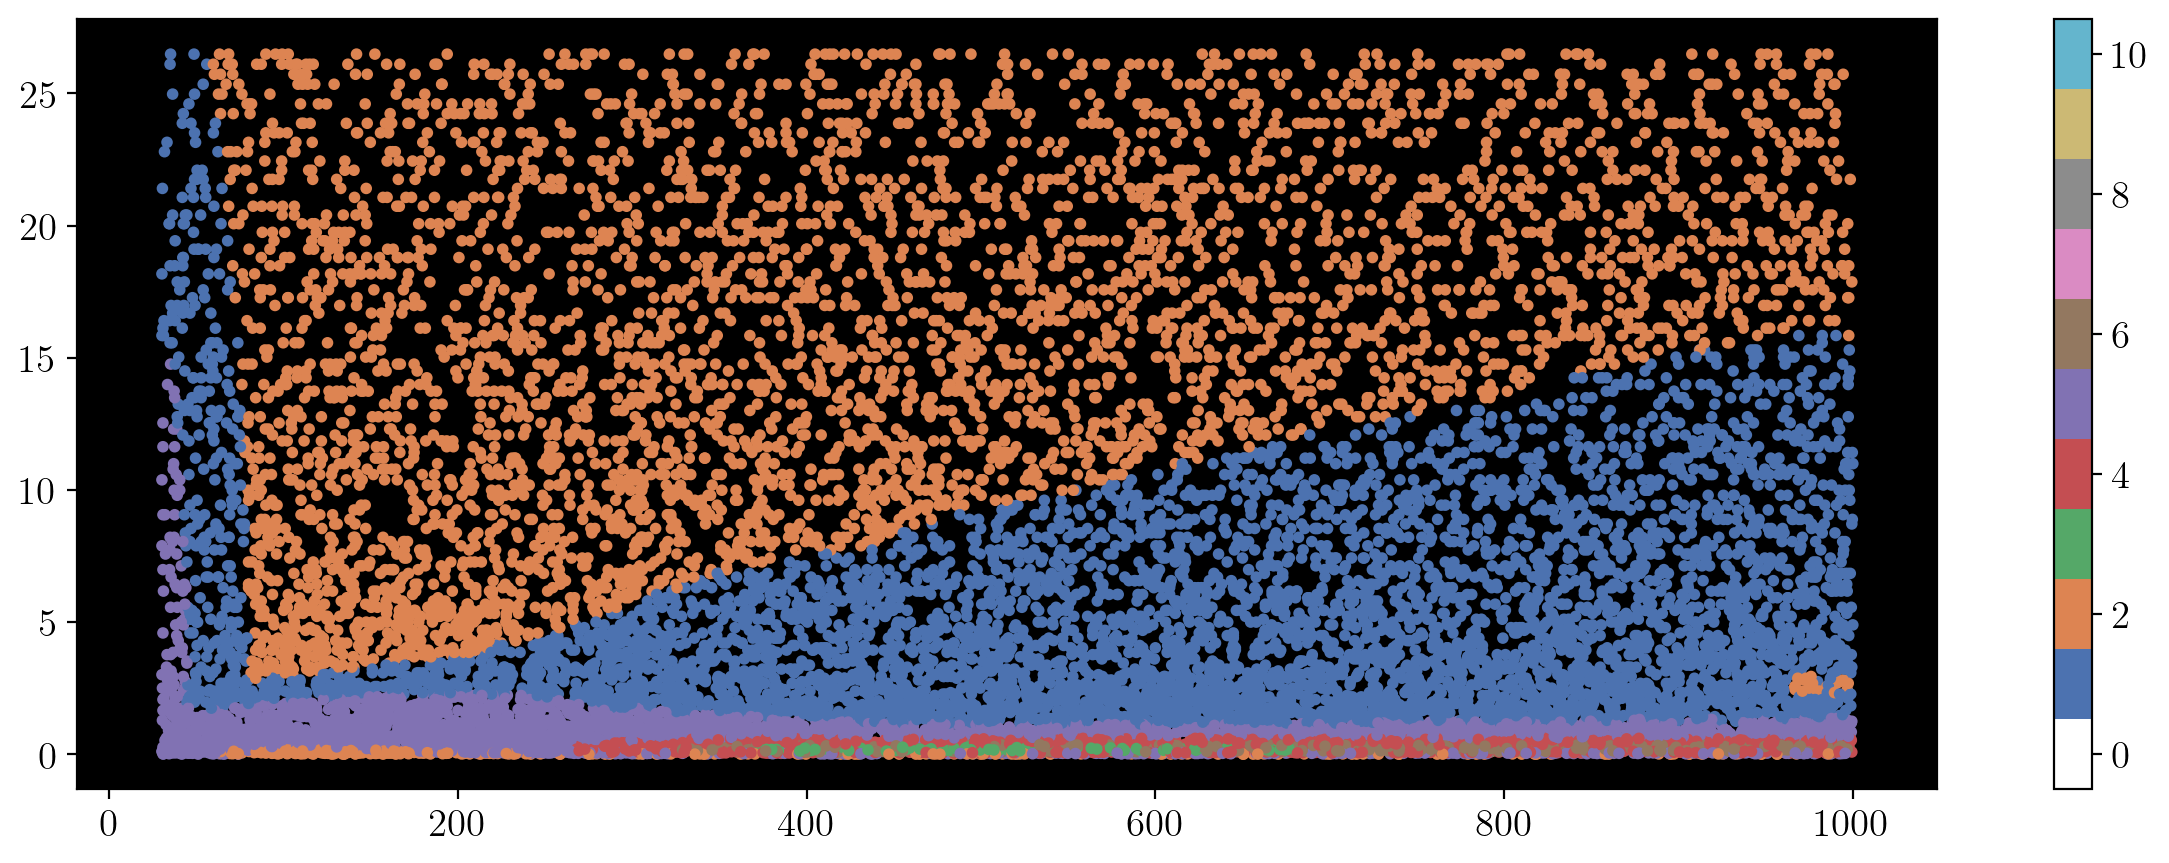

In [146]:
plt.figure(figsize=(15, 5))
plt.scatter(
    features_sc[:, 6],
    features_sc[:, 7],
    c=cluster_idx + 1,
    vmin=-0.5,
    vmax=cm.N - 0.5,
    cmap=cm,
    s=10,
)
ax = plt.gca()
ax.set_facecolor("#000000")
plt.colorbar()

## b. Sparce Principal Component Analysis (SPCA) dimensionality reduction

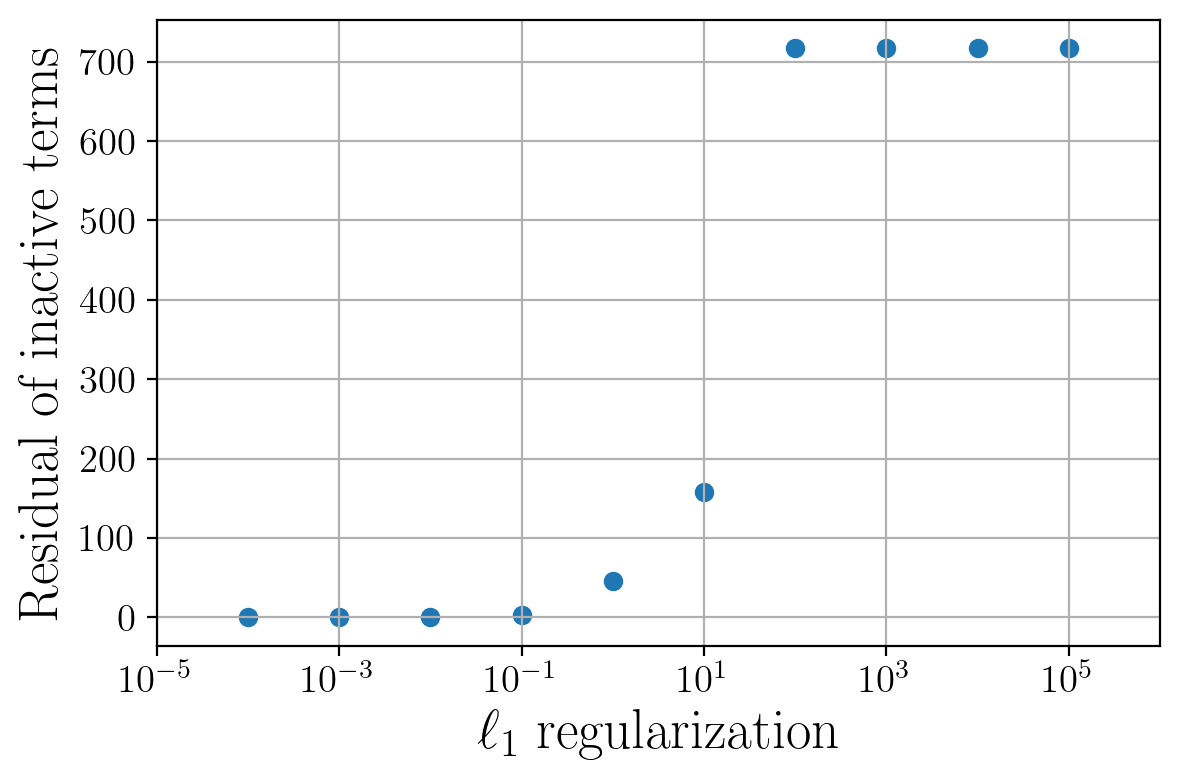

In [114]:
# Sparse PCA to identify directions of nonzero variance in each cluster

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])
sparsity = np.zeros([len(alphas)])
cluster_idx = cluster_idx - 1

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx == i)[0]
        cluster_features = features_sc[feature_idx, :6]

        # Conduct Sparse PCA
        spca = SparsePCA(
            n_components=1, alpha=alphas[k], random_state=seed
        )  # normalize_components=True
        spca.fit(cluster_features)

        # Identify active and terms
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms]

        # Calculate the error, as the sum of the norms of the inactive terms
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])

pf.plot_spca_residuals(alphas, err)

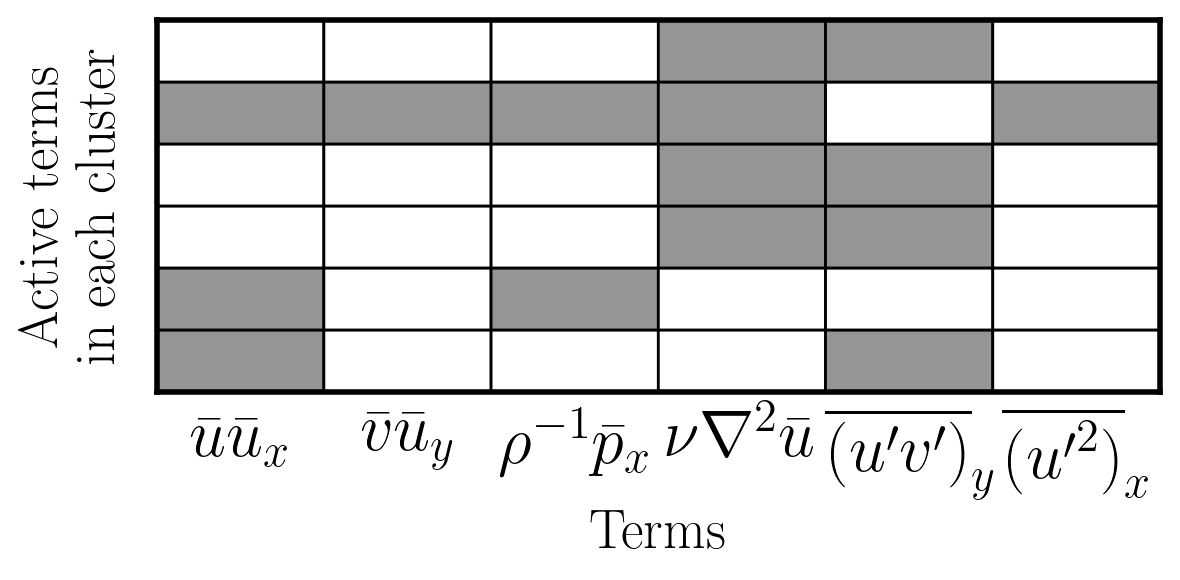

In [148]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 1  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features_sc[feature_idx, :6]

    spca = SparsePCA(
        n_components=1, alpha=alpha_opt, random_state=seed
    )  # normalize_components=True
    spca.fit(cluster_features)

    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

# Plot the active terms for each cluster
pf.plot_active_terms(spca_model, labels)

## c. Resulting Final Dominant Balance Models

In [141]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

# Print balance models
for i in range(nmodels):
    print("SPCA Cluster {0}:".format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
    else:
        print("No dynamics")

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])

[[0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1.]]
SPCA Cluster 0:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\rho^{-1} \\bar{p}_x$']
SPCA Cluster 3:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\rho^{-1} \\bar{p}_x$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{({u^\\prime} ^2)}_x$']


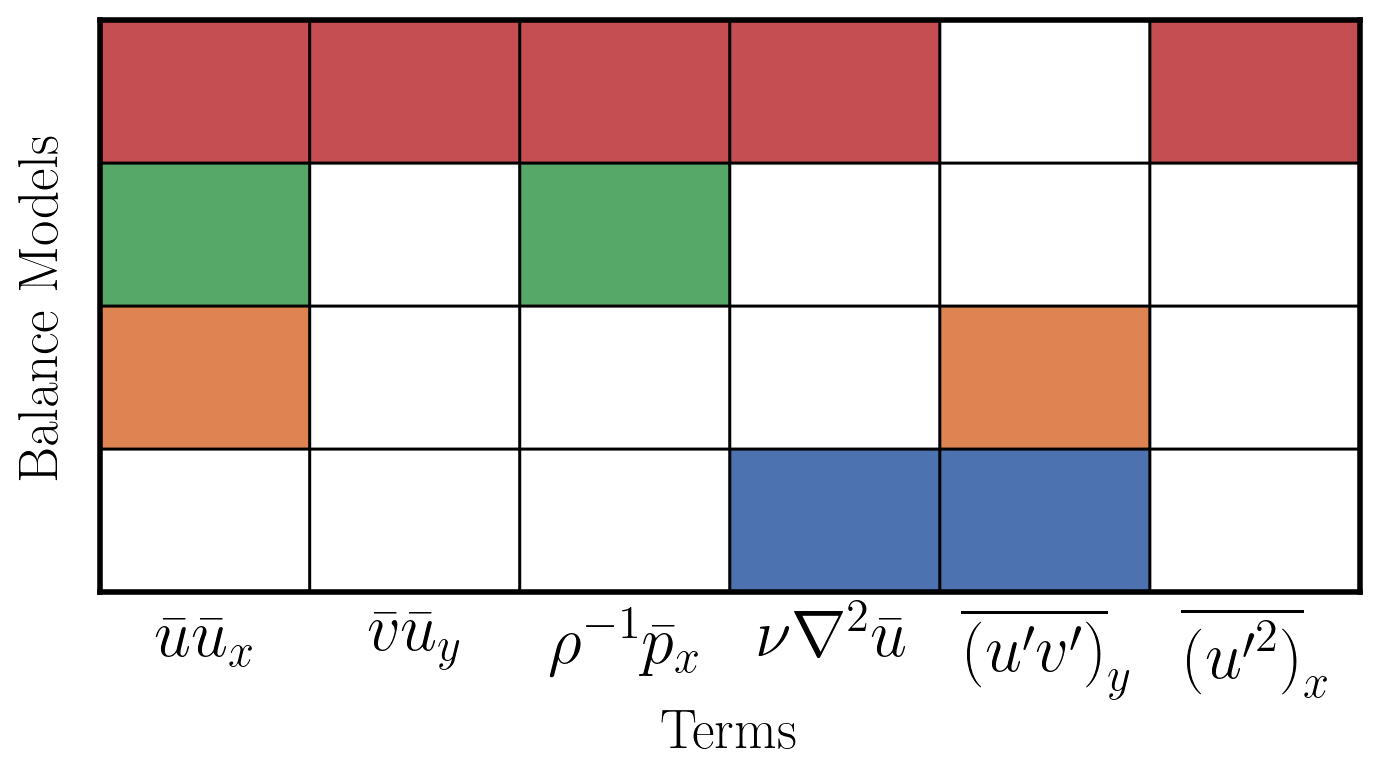

In [142]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap == 0
gridmap = (gridmap.T * np.arange(nmodels)).T + 1
gridmap[gridmask] = 0

# Delete unused terms
grid_mask = np.nonzero(np.all(gridmap == 0, axis=0))[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

pf.plot_balance_models(gridmap, grid_labels)

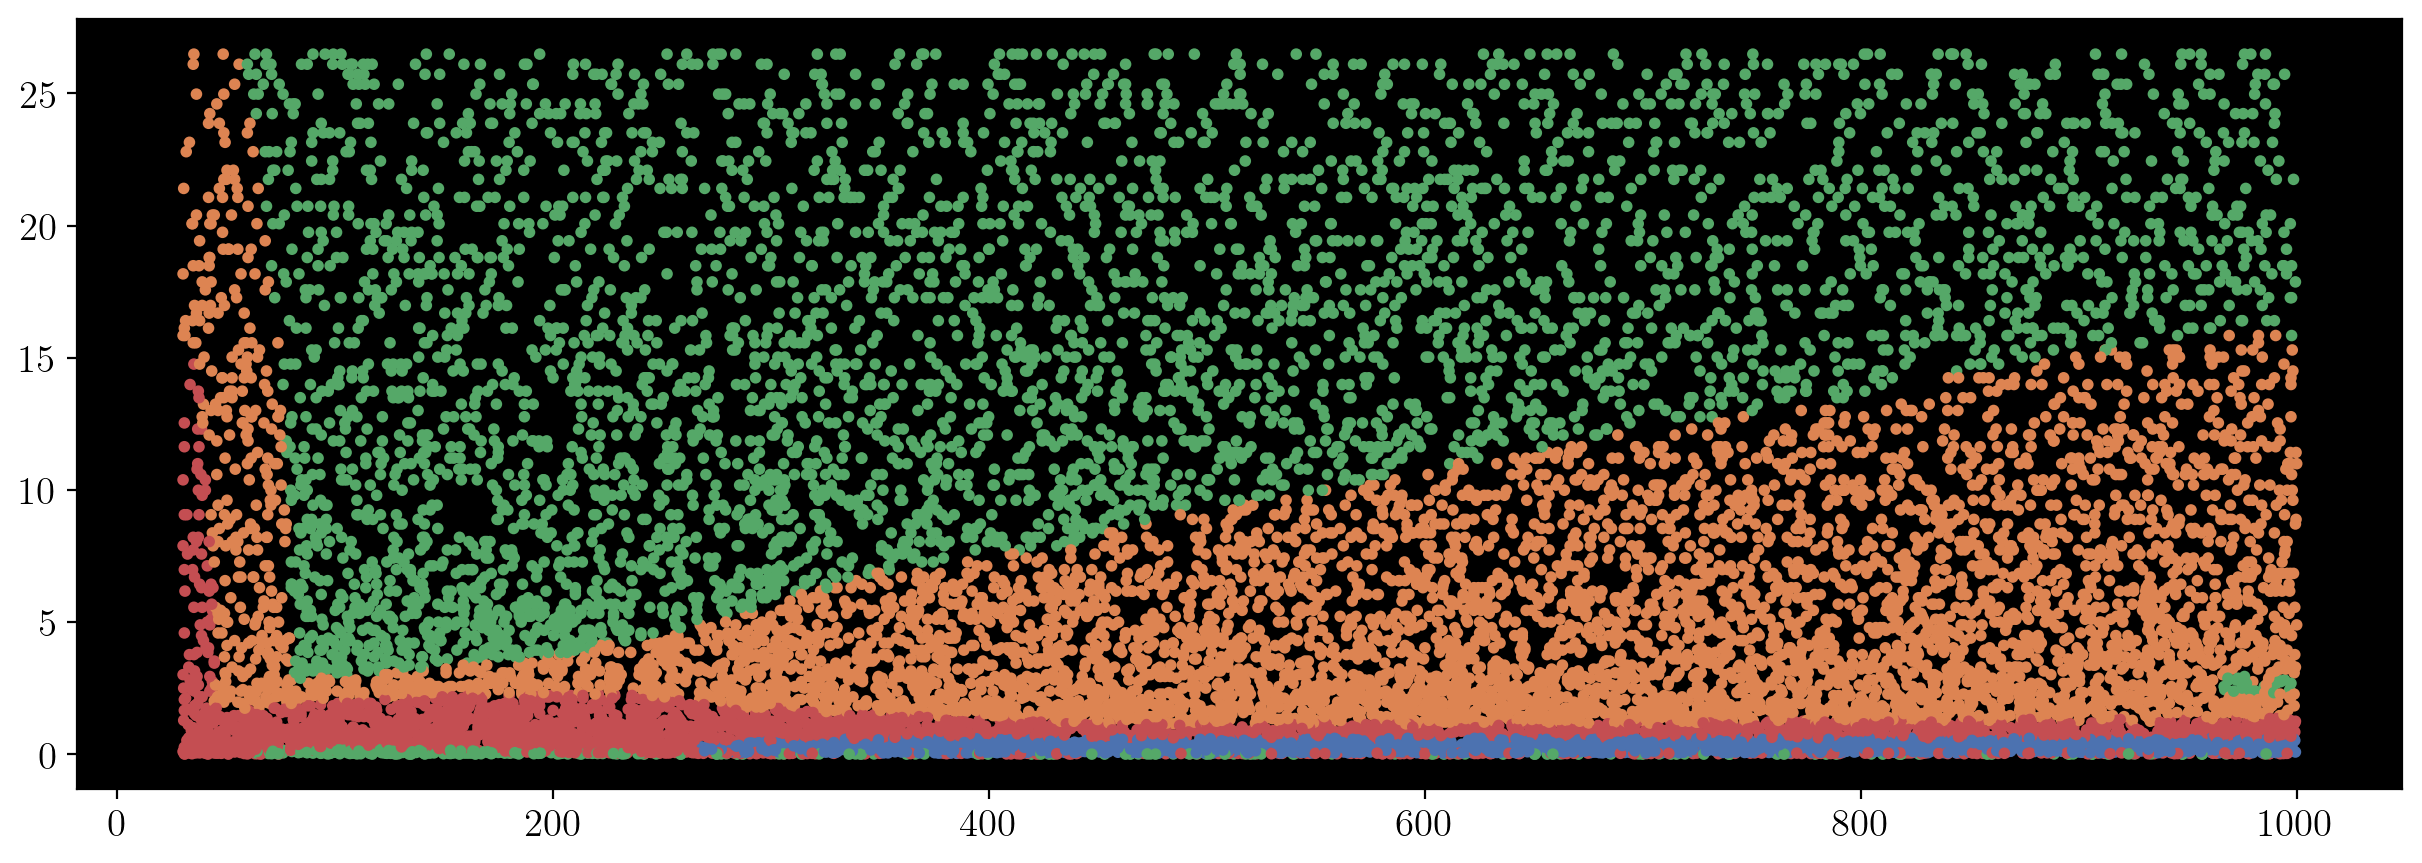

In [144]:
# Plot the clustering in space
plt.figure(figsize=(15, 5))
plt.scatter(
    features_sc[:, 6],
    features_sc[:, 7],
    c=balance_idx + 1,
    vmin=-0.5,
    vmax=cm.N - 0.5,
    cmap=cm,
    s=10,
)
ax = plt.gca()
ax.set_facecolor("#000000")

Here, a different optimal complexity value was used for the SPCA,

Similar dominant balance regimes are identified, though they have some differences.